In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression  # solo uso esta en la reg lineal
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
import scipy as sp
import scipy.stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import STL
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import numpy as np
import sklearn


# Carga de los datos

In [2]:
import os
os.chdir("C:\\Users\\LENOVO\\Desktop\\Universidad\\Series de tiempo\\Series_de_tiempo")

In [3]:
# Cargar el archivo CSV
energia = pd.read_csv("energia.csv")
print(energia)

           fecha  Energia
0     2004-10-01   254046
1     2004-10-02   318280
2     2004-10-03   293620
3     2004-10-04   333971
4     2004-10-05   347423
...          ...      ...
5049  2018-07-29   326291
5050  2018-07-30   362481
5051  2018-07-31   367135
5052  2018-08-01   363979
5053  2018-08-02   371807

[5054 rows x 2 columns]


A continuación se presenta la gráfica de la serie de tiempo.

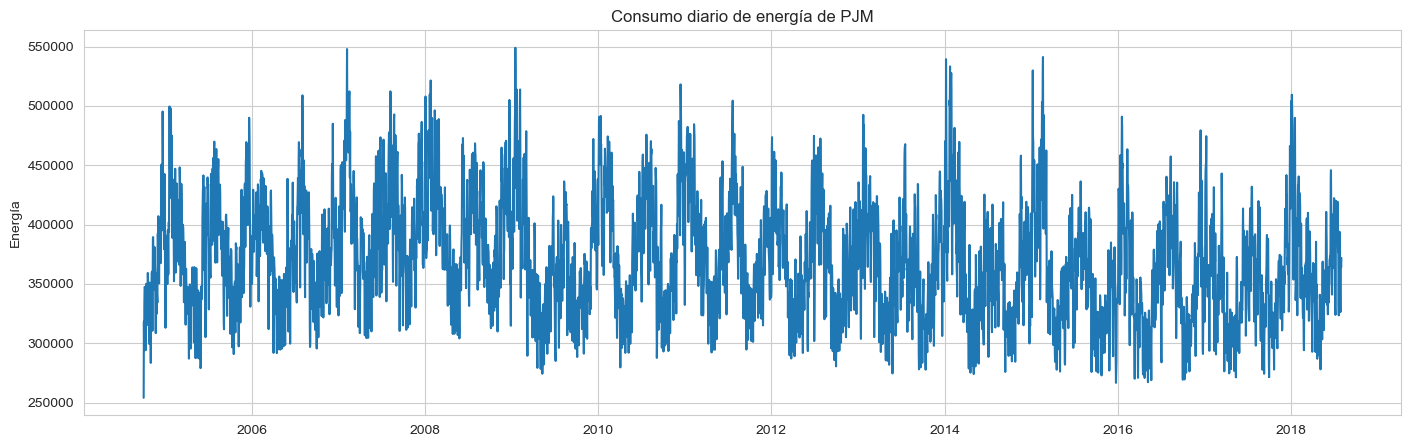

In [94]:
energia['fecha']=pd.to_datetime(energia['fecha']) # pasar a formato fecha
Valores_energia=energia.set_index('fecha') # nuevo dataframe indexado por la fecha
Valores_energia['Energia'] = pd.to_numeric(Valores_energia['Energia'], errors='coerce')
energia_ts=Valores_energia['Energia'] # vector con los valores de la serie

# Serie de tiempo
plt.plot(energia_ts)
plt.title('Consumo diario de energía de PJM')
plt.ylabel('Energía')
plt.show()

In [5]:
indice = pd.date_range(start='1/1/2004', periods=5054, freq='D')
indice
energiats =pd.Series(energia['Energia'].values,index=indice)
energiadf =pd.DataFrame(energia['Energia'].values,index=indice)

# Árboles de decisión

## Creación de variables rezagadas

Dado que el consumo de energía no varía tanto de un día a otro, se toma el último rezago para hacer la predicción un paso hacia adelante con árboles de decisión.

In [6]:
from pandas import DataFrame

df1 = DataFrame()
print(df1)

for i in range(1,0,-1):
    df1[['t-'+str(i)]] = energiadf.shift(i)

print(df1)

Empty DataFrame
Columns: []
Index: []
                 t-1
2004-01-01       NaN
2004-01-02  254046.0
2004-01-03  318280.0
2004-01-04  293620.0
2004-01-05  333971.0
...              ...
2017-10-28  345439.0
2017-10-29  326291.0
2017-10-30  362481.0
2017-10-31  367135.0
2017-11-01  363979.0

[5054 rows x 1 columns]


In [7]:
df1['t'] = energiadf.values
print(df1.head(13))

                 t-1       t
2004-01-01       NaN  254046
2004-01-02  254046.0  318280
2004-01-03  318280.0  293620
2004-01-04  293620.0  333971
2004-01-05  333971.0  347423
2004-01-06  347423.0  347392
2004-01-07  347392.0  345767
2004-01-08  345767.0  346574
2004-01-09  346574.0  316377
2004-01-10  316377.0  294234
2004-01-11  294234.0  334600
2004-01-12  334600.0  350135
2004-01-13  350135.0  346924


In [8]:
df1_energia = df1[1:]
print(df1_energia)
df1_energia.size

                 t-1       t
2004-01-02  254046.0  318280
2004-01-03  318280.0  293620
2004-01-04  293620.0  333971
2004-01-05  333971.0  347423
2004-01-06  347423.0  347392
...              ...     ...
2017-10-28  345439.0  326291
2017-10-29  326291.0  362481
2017-10-30  362481.0  367135
2017-10-31  367135.0  363979
2017-11-01  363979.0  371807

[5053 rows x 2 columns]


10106

## Partición de los datos

Del total de datos, se selecciona un grupo para entrenamiento, el cual corresponde al $70\%$, validación $10\%$ y prueba $20\%$.

In [9]:
energiasplit = df1_energia.values
X1= energiasplit[:, 0:-1] 
y1 =energiasplit[:,-1]

Se tiene el siguiente tamaño para cada uno de los grupos, tanto para la variable respuesta como para las variable predictora.

In [13]:
Y1 = y1
print('Complete Observations for Target after Supervised configuration: %d' %len(Y1))
traintarget_size = int(len(Y1) * 0.70) 
valtarget_size = int(len(Y1) * 0.10)+1# Set split
testtarget_size = int(len(Y1) * 0.20)# Set split
print(traintarget_size,valtarget_size,testtarget_size)
print('Train + Validation + Test: %d' %(traintarget_size+valtarget_size+testtarget_size))

train_target, val_target,test_target = Y1[0:traintarget_size],Y1[(traintarget_size):(traintarget_size+valtarget_size)] ,Y1[(traintarget_size+valtarget_size):len(Y1)]

print('Observaciones respuesta: %d' % (len(Y1)))
print('Observaciones para entrenamiento: %d' % (len(train_target)))
print('Observaciones para validación: %d' % (len(val_target)))
print('Observaciones para prueba: %d' % (len(test_target)))

Complete Observations for Target after Supervised configuration: 5053
3537 506 1010
Train + Validation + Test: 5053
Observaciones respuesta: 5053
Observaciones para entrenamiento: 3537
Observaciones para validación: 506
Observaciones para prueba: 1010


In [14]:
trainfeature_size = int(len(X1) * 0.70)
valfeature_size = int(len(X1) * 0.10)+1
testfeature_size = int(len(X1) * 0.20)
train_feature, val_feature,test_feature = X1[0:traintarget_size],X1[(traintarget_size):(traintarget_size+valtarget_size)] ,X1[(traintarget_size+valtarget_size):len(Y1)]

print('Observations for Feature: %d' % (len(X1)))
print('Training Observations for Feature: %d' % (len(train_feature)))
print('Validation Observations for Feature: %d' % (len(val_feature)))
print('Test Observations for Feature: %d' % (len(test_feature)))

Observations for Feature: 5053
Training Observations for Feature: 3537
Validation Observations for Feature: 506
Test Observations for Feature: 1010


## Modelo de regresión de árboles de decisión

Se crea un modelo de árboles de decisión con los argumentos preestablecidos y sin definir la profundidad máxima.

In [16]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree_energia = DecisionTreeRegressor()  # max-depth not set
# The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# Fit the model to the training features(covariables) and targets(respuestas)
decision_tree_energia.fit(train_feature, train_target)

# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_energia.score(train_feature, train_target))
print("Coeficiente R2 sobre el conjunto de Validación:",decision_tree_energia.score(val_feature,val_target))  # predictions are horrible if negative value, no relationship if 0
print("el RECM es:",(((decision_tree_energia.predict(val_feature)-val_target)**2).mean())**0.5)

Coeficiente R2 sobre el conjunto de entrenamiento: 0.9954964958559707
Coeficiente R2 sobre el conjunto de Validación: 0.4097449076477846
el RECM es: 34771.057455953756


Se puede notar que el $R^2$ sobre el conjunto de entrenamiento es cercano a $1$, y para el conjunto de validación es $0.4097$ lo cual deja ver un sobreajuste, ya que es muy bueno para el conjunto de entrenamiento, y no tan bueno para el conjunto de validación. Se tiene un **RECM** de $34771.057$.  

En la siguiente salida se observa el $R^2$ para el conjunto de entrenamiento y validación, así como el **RECM** para diferentes profundidades del árbol de decisión.

In [17]:
for d in [2, 3, 4, 5,6,7,8,9,10]:
    # Create the tree and fit it
    decision_tree_energia = DecisionTreeRegressor(max_depth=d)
    decision_tree_energia.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('\n max_depth=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_energia.score(train_feature, train_target))
    print("Coeficiente R2 sobre el conjunto de validación:",decision_tree_energia.score(val_feature, val_target), '\n')  # You want the test score to be positive and high
    print("el RECM sobre el conjunto de validación es:",sklearn.metrics.mean_squared_error(decision_tree_energia.predict(val_feature),val_target, squared=False),'\n')


 max_depth= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.6658483415029792
Coeficiente R2 sobre el conjunto de validación: 0.6379069099585852 

el RECM sobre el conjunto de validación es: 27233.793862222934 


 max_depth= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7097063378219218
Coeficiente R2 sobre el conjunto de validación: 0.6851744251888441 

el RECM sobre el conjunto de validación es: 25394.111948551046 


 max_depth= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.723631791462201
Coeficiente R2 sobre el conjunto de validación: 0.7012392372255509 

el RECM sobre el conjunto de validación es: 24737.727836712194 


 max_depth= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7317391201183263
Coeficiente R2 sobre el conjunto de validación: 0.6675182179901309 

el RECM sobre el conjunto de validación es: 26096.4813372375 


 max_depth= 6
Coeficiente R2 sobre el conjunto de entrenamiento: 0.739156304288221
Coeficiente R2 sobre el conjunto de validac

Se puede notar que el menor valor de **RECM** corresponde a una profundidad de $4$, así mismo se tiene un $R^2$ alto para el conjunto de entrenamiento y validación. 

### Juntamos entrenamiento y validación

In [18]:
print(type(train_feature))
print(type(val_feature))

#######

print(type(train_target))
print(type(val_target))

####
print(train_feature.shape)
print(val_feature.shape)

#####

####
print(train_target.shape)
print(val_target.shape)

###Concatenate Validation and test

train_val_feature=np.concatenate((train_feature,val_feature),axis=0)
train_val_target=np.concatenate((train_target,val_target),axis=0)
print(train_val_feature.shape)
print(train_val_target.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3537, 1)
(506, 1)
(3537,)
(506,)
(4043, 1)
(4043,)


Se realiza la predicción un paso adelante utilizando los datos sumados de entrenamiento y validación, con una profundidad de $4$.

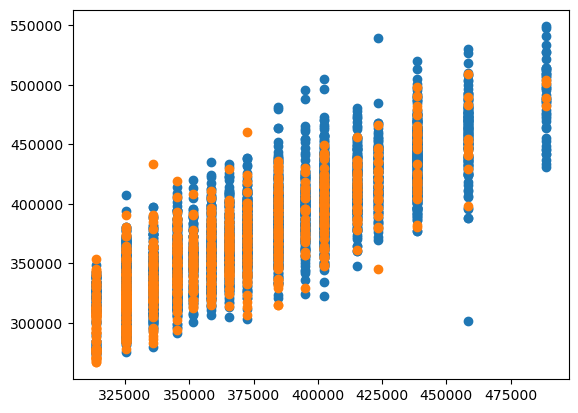

Raíz de la Pérdida cuadrática Entrenamiento: 24541.887821458102
Raíz de la Pérdida cuadrática Prueba: 24187.583840079464


In [19]:
from matplotlib import pyplot as plt

decision_tree_energia = DecisionTreeRegressor(max_depth=4)  # fill in best max depth here
decision_tree_energia.fit(train_val_feature, train_val_target)

# Prediciendo valores para entrenamiento y prueba 
train_val_prediction = decision_tree_energia.predict(train_val_feature)
test_prediction = decision_tree_energia.predict(test_feature)

# Comparación de los valores predichos vs los reales 
plt.scatter(train_val_prediction, train_val_target, label='train')  # blue
plt.scatter(test_prediction, test_target, label='test')  # orange
plt.show()
print("Raíz de la Pérdida cuadrática Entrenamiento:",sklearn.metrics.mean_squared_error( train_val_prediction, train_val_target,squared=False))

print("Raíz de la Pérdida cuadrática Prueba:",sklearn.metrics.mean_squared_error(test_prediction, test_target,squared=False))

Se obtienen **RECM** parecidos para los conjuntos de entrenamiento y prueba, lo que indicaría un buen ajuste del modelo.

A continuación se presentan el árbol de decisión.

In [20]:
from sklearn import tree

listacaract=list(df1_energia.columns.values)
respuesta=listacaract.pop()
text_representation = tree.export_text(decision_tree_energia)
print(text_representation)

|--- feature_0 <= 378188.00
|   |--- feature_0 <= 348645.50
|   |   |--- feature_0 <= 328189.50
|   |   |   |--- feature_0 <= 298872.00
|   |   |   |   |--- value: [313578.27]
|   |   |   |--- feature_0 >  298872.00
|   |   |   |   |--- value: [325523.36]
|   |   |--- feature_0 >  328189.50
|   |   |   |--- feature_0 <= 338234.50
|   |   |   |   |--- value: [336032.19]
|   |   |   |--- feature_0 >  338234.50
|   |   |   |   |--- value: [345127.24]
|   |--- feature_0 >  348645.50
|   |   |--- feature_0 <= 360920.50
|   |   |   |--- feature_0 <= 352670.50
|   |   |   |   |--- value: [351439.62]
|   |   |   |--- feature_0 >  352670.50
|   |   |   |   |--- value: [358306.15]
|   |   |--- feature_0 >  360920.50
|   |   |   |--- feature_0 <= 367877.50
|   |   |   |   |--- value: [365440.42]
|   |   |   |--- feature_0 >  367877.50
|   |   |   |   |--- value: [372495.87]
|--- feature_0 >  378188.00
|   |--- feature_0 <= 425589.50
|   |   |--- feature_0 <= 397860.50
|   |   |   |--- feature_0 <

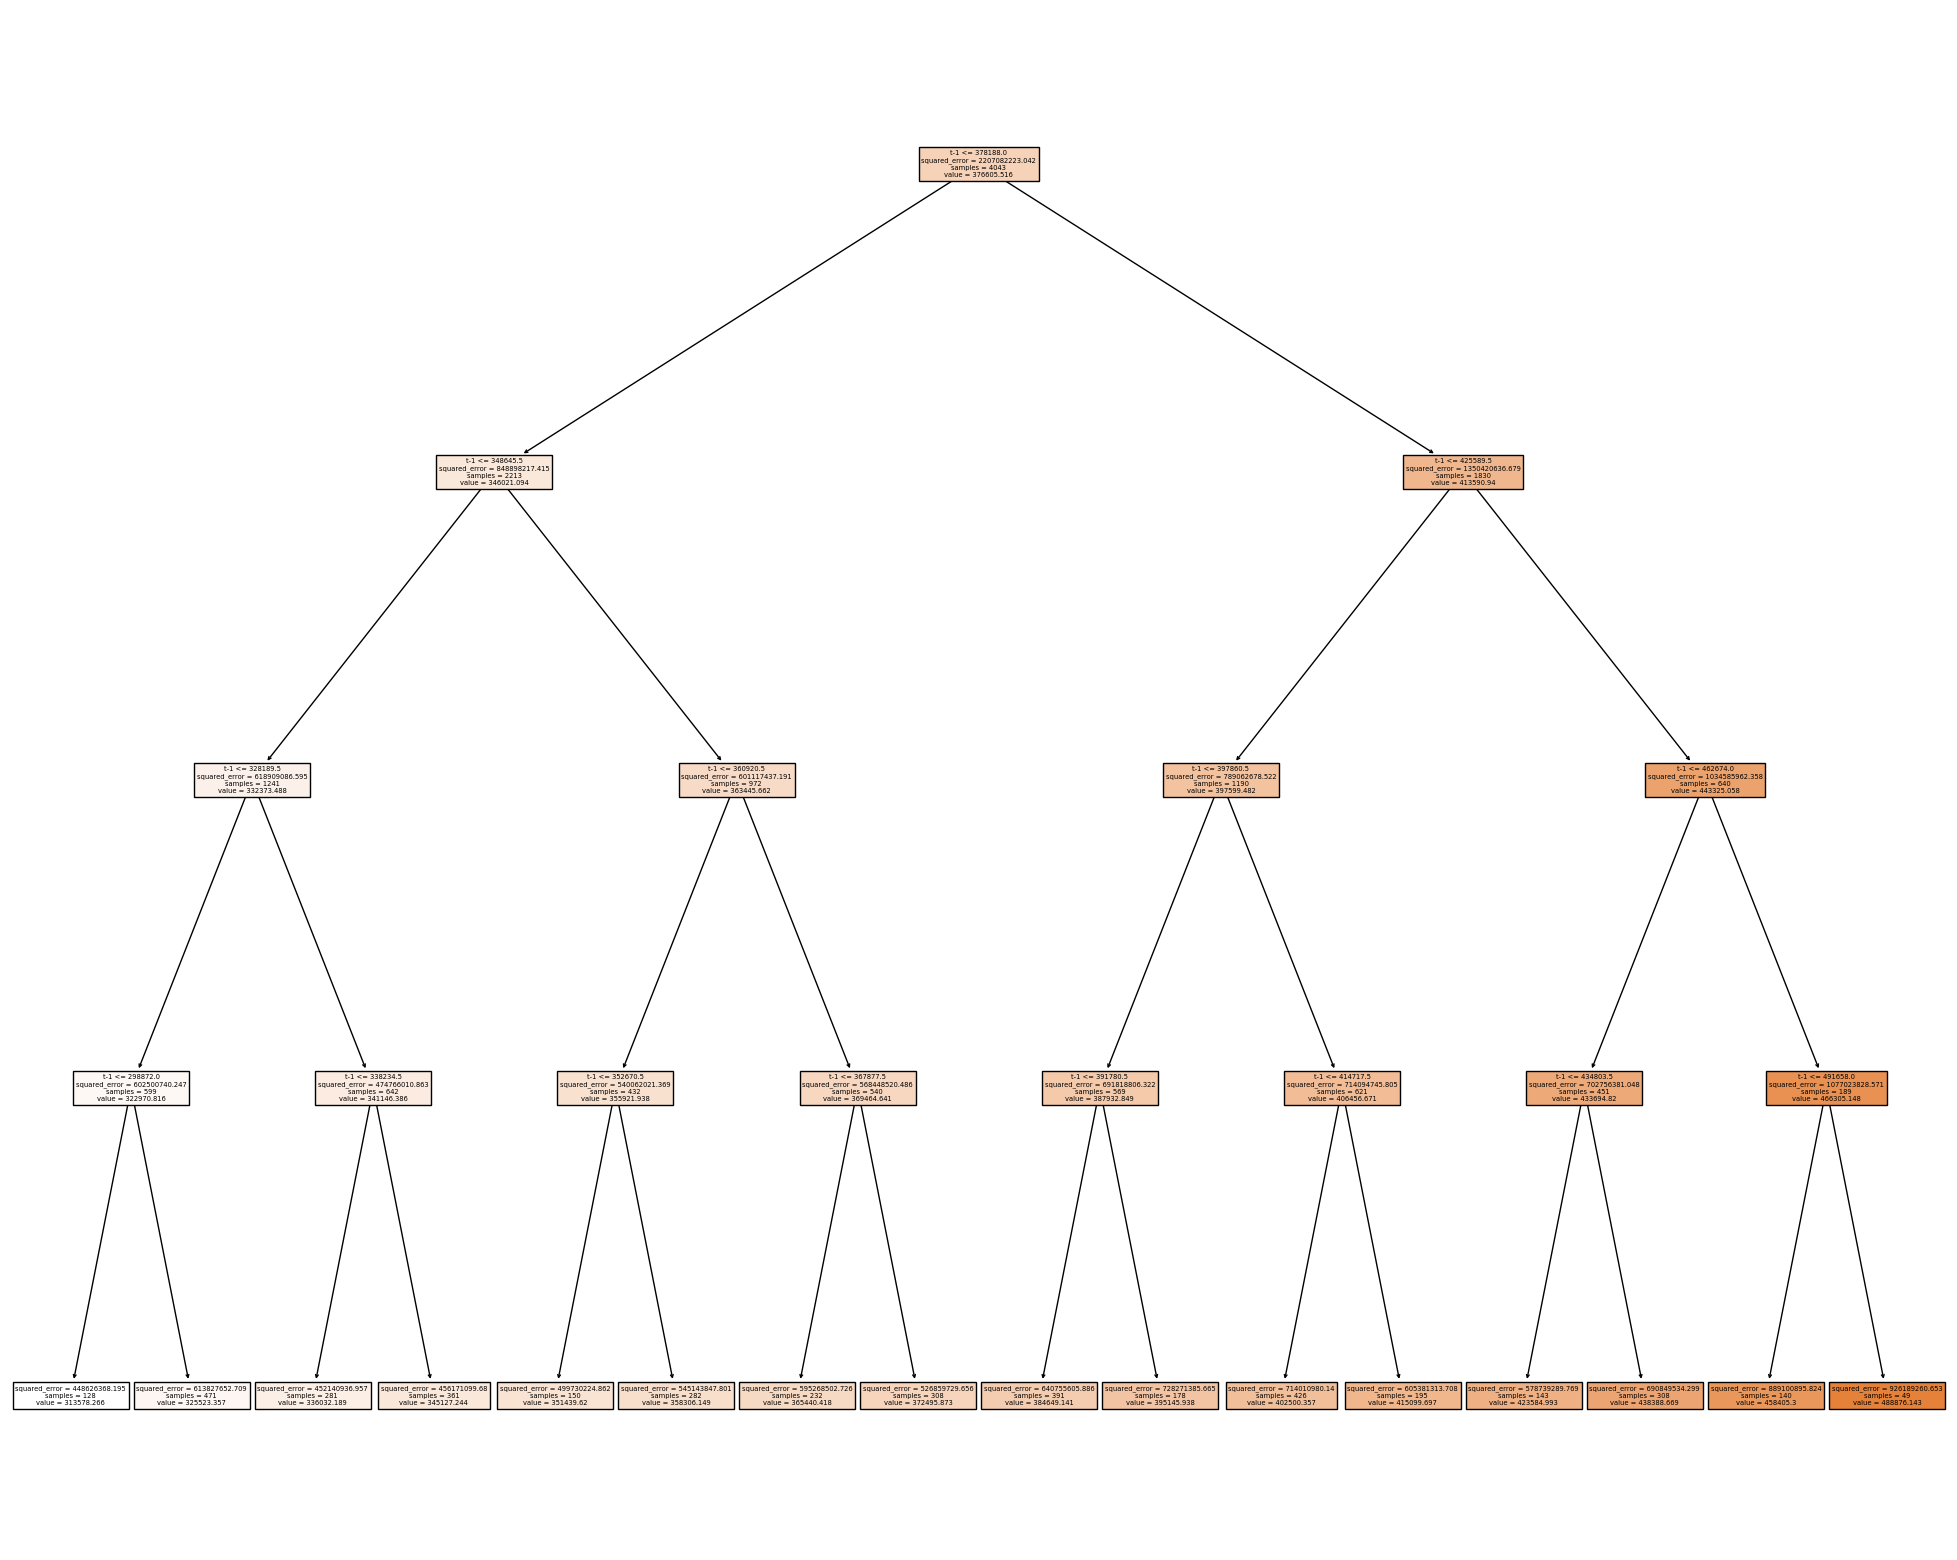

In [21]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_energia, 
                   feature_names=listacaract,  
                   class_names=['t'],
                   filled=True)

In [24]:
print(train_val_prediction.size)
print(train_val_target.size)

print(test_prediction.size)
print(test_target.size)

4043
4043
1010
1010


In [25]:
indicetrian_val_test=df1_energia.index
print(indicetrian_val_test.size)  ###Tamaño del índice
indicetrain_val=indicetrian_val_test[0:3749]
indicetest=indicetrian_val_test[3749:4686]

5053


In [26]:
targetjoint=np.concatenate((train_val_target,test_target))
predictionjoint=np.concatenate((train_val_prediction,test_prediction))
print(targetjoint.size)
print(predictionjoint.size)

5053
5053


Se muestra a continuación el valor observado y el valor predicho.

In [28]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=indicetrian_val_test)
ObsvsPred.head(10)

,observado,Predicción
2004-01-02,318280.0,313578.265625
2004-01-03,293620.0,325523.356688
2004-01-04,333971.0,313578.265625
2004-01-05,347423.0,336032.188612
2004-01-06,347392.0,345127.243767
2004-01-07,345767.0,345127.243767
2004-01-08,346574.0,345127.243767
2004-01-09,316377.0,345127.243767
2004-01-10,294234.0,325523.356688
2004-01-11,334600.0,313578.265625


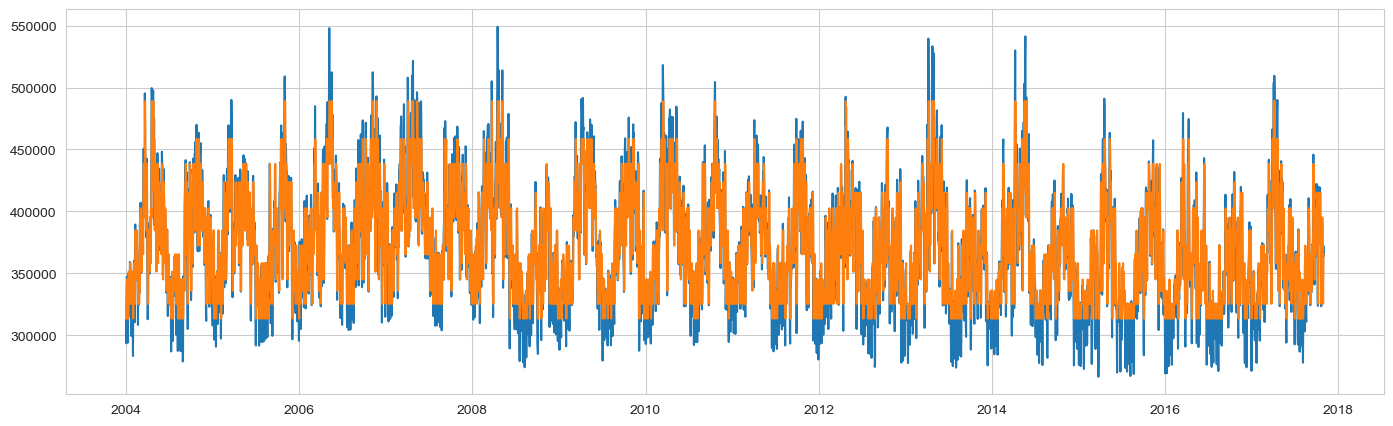

In [150]:
plt.plot(ObsvsPred)

Se puede observar que el modelo se ajusta bien a los datos, sin dejarse influenciar mucho por los valores más extremos.

# Redes neuronales

In [29]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.14.0
Pandas Version: 2.0.3
Numpy Version: 1.24.3
System Version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [30]:
import IPython
import IPython.display

In [31]:
df=energia
display(df.head())

,fecha,Energia
0,2004-10-01,254046
1,2004-10-02,318280
2,2004-10-03,293620
3,2004-10-04,333971
4,2004-10-05,347423


In [32]:
features_considered = ['Energia']

In [33]:
features = df[features_considered]
features.index = df['fecha']
features.head()

,Energia
fecha,
2004-10-01,254046
2004-10-02,318280
2004-10-03,293620
2004-10-04,333971
2004-10-05,347423


Nuevamente se presenta la gráfica de la serie de tiempo.

<Axes: xlabel='fecha'>

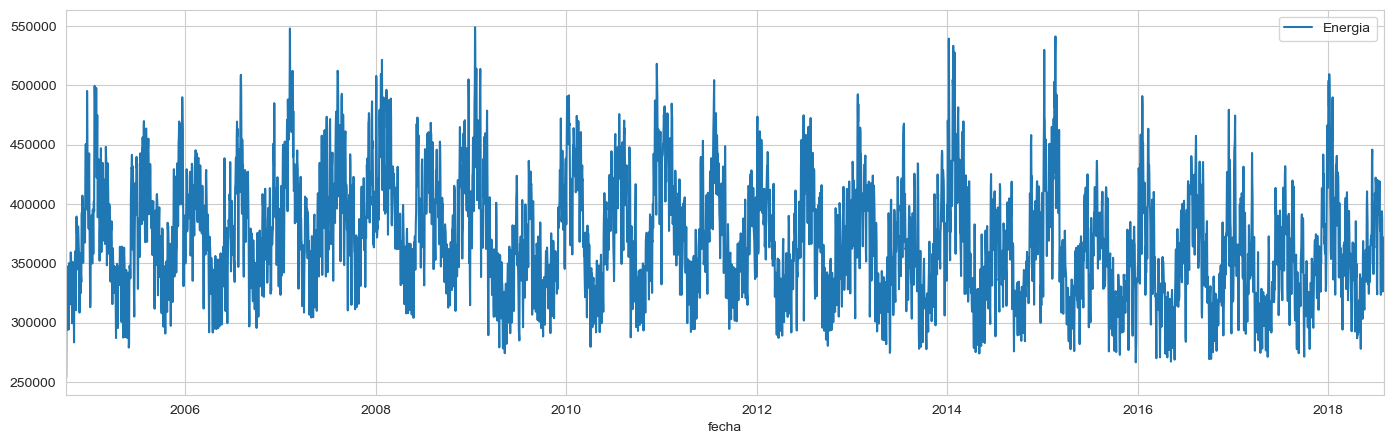

In [37]:
features.plot()

In [38]:
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.8)]
test_df = features[int(n*0.8):]

num_features = features.shape[1]

Se normalizan los datos para estabilizar la varianza marginal no constante y la tendencia en caso de que la serie tuviera.

In [39]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [40]:
train_df

,Energia
fecha,
2004-10-01,-2.670644
2004-10-02,-1.297470
2004-10-03,-1.824644
2004-10-04,-0.962033
2004-10-05,-0.674461
...,...
2014-06-03,0.052573
2014-06-04,-0.307556
2014-06-05,-0.754734


Se presenta el tamaño de los conjuntos de entrenamiento, validación y prueba.

In [42]:
print("longitud dataframe entrenamiento:",train_df.shape)
print("longitud dataframe validación:",val_df.shape)
print("longitud dataframe prueba:",test_df.shape)

longitud dataframe entrenamiento: (3537, 1)
longitud dataframe validación: (506, 1)
longitud dataframe prueba: (1011, 1)


# Window Generator

In [43]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


# Split

In [44]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# Objetos a tensor flow

In [45]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=128,) ##### Tamaño del lote

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [46]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Definir las gráficas

In [47]:
def plot(self, model=None, plot_col='Energia', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

# Configuración para el modelo de los ajustes

In [48]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Empezar

Se realiza la predicción un paso hacia adelante con un único rezago, dado que el consumo de energía no varía mucho de un día a otro.

In [49]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Energia'])# La variable a predecir es T (degC)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Energia']

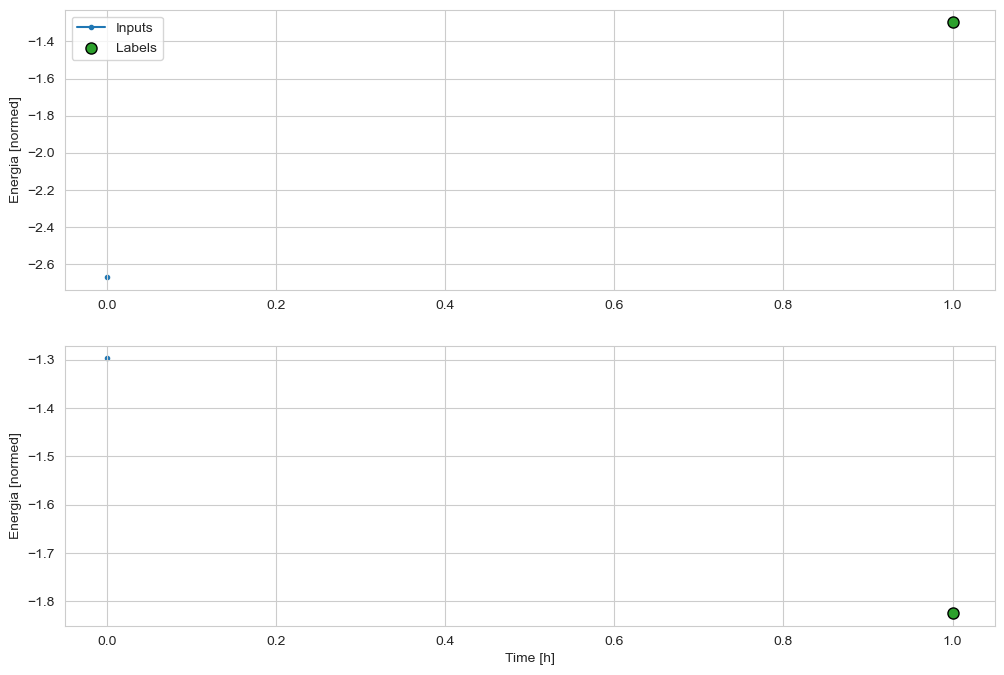

In [50]:
single_step_window.plot()

In [51]:
i=1
for batch in single_step_window.train.take(2):
    inputs, targets = batch
    print("Covariable o input del lote",i,inputs)
    print("Respuesta o etiqueta del lote ",i,targets)
    print("tipo de objeto inputs del lote",i,type(inputs))
    i=i+1

Covariable o input del lote 1 tf.Tensor(
[[[-2.6706438 ]]

 [[-1.2974703 ]]

 [[-1.8246437 ]]

 [[-0.9620333 ]]

 [[-0.67446077]]

 [[-0.6751235 ]]

 [[-0.70986223]]

 [[-0.69261044]]

 [[-1.338152  ]]

 [[-1.8115178 ]]

 [[-0.9485867 ]]

 [[-0.6164845 ]]

 [[-0.6851283 ]]

 [[-0.6690095 ]]

 [[-0.62644655]]

 [[-1.0188551 ]]

 [[-1.3571568 ]]

 [[-0.42218286]]

 [[-0.4265653 ]]

 [[-0.6395938 ]]

 [[-0.713924  ]]

 [[-0.69622326]]

 [[-1.2047126 ]]

 [[-1.6986223 ]]

 [[-0.8664323 ]]

 [[-0.595962  ]]

 [[-0.6682185 ]]

 [[-0.72439903]]

 [[-0.75580287]]

 [[-1.3297292 ]]

 [[-2.042525  ]]

 [[-0.9536318 ]]

 [[-0.63613063]]

 [[-0.60759145]]

 [[-0.42757004]]

 [[-0.39759853]]

 [[-0.78953683]]

 [[-1.4630618 ]]

 [[-0.64549404]]

 [[ 0.21495733]]

 [[ 0.22447039]]

 [[-0.08871253]]

 [[-0.078494  ]]

 [[-0.5909168 ]]

 [[-0.72662234]]

 [[ 0.02950601]]

 [[ 0.0448338 ]]

 [[-0.18360803]]

 [[-0.31954864]]

 [[-0.44747266]]

 [[-1.1320071 ]]

 [[-1.5063944 ]]

 [[-0.6318551 ]]

 [[-0

In [53]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [54]:
baseline = Baseline(label_index=column_indices['Energia'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

4/4 [==============================] - 0s 9ms/step - loss: 0.3003 - mean_absolute_error: 0.4194


In [55]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,label_columns=['Energia'])


wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Energia']

In [56]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (128, 30, 1)
Output shape: (128, 30, 1)


A continuación se pueden notar los valores de la serie y las predicciones realizadas por el modelo base.

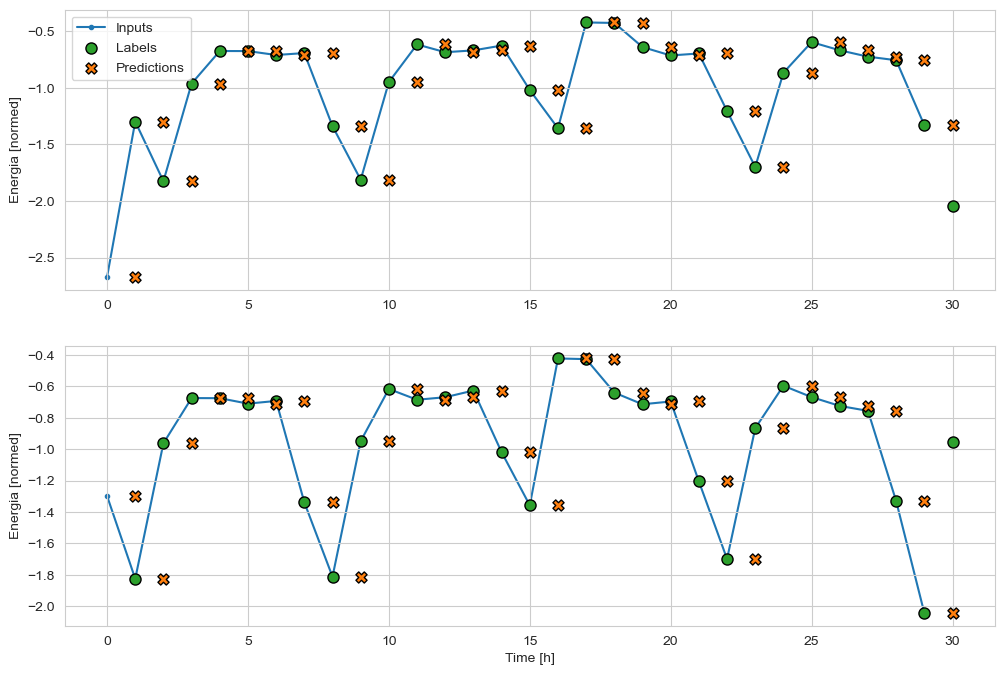

In [58]:
wide_window.plot(baseline)

# Multicapa

## Tuning o búsqueda de los hiperparámetros

In [59]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

Using TensorFlow backend


In [60]:
for batch in single_step_window.train.take(1):
    inputs_train,targets_train = batch
    
print("Input shape:", inputs_train.numpy().shape)
print("Target shape:", targets_train.numpy().shape)

Input shape: (128, 1, 1)
Target shape: (128, 1, 1)


In [61]:
for batch in single_step_window.val.take(1):
    inputs_val,targets_val = batch

print("Input shape:", inputs_val.numpy().shape)
print("Target shape:", targets_val.numpy().shape)

Input shape: (128, 1, 1)
Target shape: (128, 1, 1)


In [62]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [63]:
input_dataset_train = single_step_window.train.map(lambda x,y: x)
target_dataset_train = single_step_window.train.map(lambda x,y: y)

In [64]:
input_dataset_train

<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>

In [65]:
input_dataset_val = single_step_window.val.map(lambda x,y: x)
target_dataset_val = single_step_window.val.map(lambda x,y: y)

In [66]:
print(input_dataset_val)
print(target_dataset_val)

<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [67]:
input_dataset_test = single_step_window.test.map(lambda x,y: x)
target_dataset_test = single_step_window.test.map(lambda x,y: y)

In [68]:
print(input_dataset_test)
print(target_dataset_test)

<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [69]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

In [70]:
tuner_RandomSearch_mlp = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [71]:
tuner_RandomSearch_mlp.search_space_summary()

Search space summary
Default search space size: 6
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 564, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 564, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [72]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=0)

In [73]:
tuner_RandomSearch_mlp.search((single_step_window.train), epochs=5, validation_data=(single_step_window.val),callbacks=[stop_early])


Trial 3 Complete [00h 00m 02s]
val_loss: 0.2780846655368805

Best val_loss So Far: 0.27496689558029175
Total elapsed time: 00h 00m 07s


In [74]:
# Get the top 2 models.
models_mlp = tuner_RandomSearch_mlp.get_best_models(num_models=2)
best_model_mlp = models_mlp[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model_mlp.build(input_shape=(128, 1, 1))
best_model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (128, 1, 64)              128       
                                                                 
 dense_1 (Dense)             (128, 1, 256)             16640     
                                                                 
 dense_2 (Dense)             (128, 1, 1)               257       
                                                                 
Total params: 17025 (66.50 KB)
Trainable params: 17025 (66.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se puede notar que en la primera capa oculta se tienen $64$ unidades, en la segunda capa oculta se tiene $256$, y en la última $1$ ya que se está realizando una predicción un paso hacia adelante.

In [76]:
tuner_RandomSearch_mlp.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 1
units_0: 256
dropout: False
lr: 0.008392749910012263
Score: 0.27496689558029175

Trial 1 summary
Hyperparameters:
num_units: 512
activation: tanh
num_layers: 5
units_0: 32
dropout: True
lr: 0.0015434163927946331
units_1: 32
units_2: 32
units_3: 32
units_4: 32
Score: 0.27775222063064575

Trial 2 summary
Hyperparameters:
num_units: 64
activation: relu
num_layers: 2
units_0: 256
dropout: False
lr: 0.00020887054682357353
units_1: 160
units_2: 352
units_3: 160
units_4: 512
Score: 0.2780846655368805


In [77]:
train_plus_val=single_step_window.train.concatenate(single_step_window.val)###verificar que en efecto

In [78]:
train_plus_val

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [79]:
# Get the top 2 hyperparameters.
best_hps_mlp = tuner_RandomSearch_mlp.get_best_hyperparameters(5)
# Build the model with the best hp.
callback=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5)
model_mlp = build_model(best_hps_mlp[0])
# Fit with the entire dataset.
model_mlp.fit(train_plus_val, epochs=10,callbacks=[callback])

Epoch 1/10
32/32 [==============================] - 1s 11ms/step - loss: 0.4244 - mean_squared_error: 0.4244
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2875 - mean_squared_error: 0.2875
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2896 - mean_squared_error: 0.2896
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2895 - mean_squared_error: 0.2895
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2893 - mean_squared_error: 0.2893
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2890 - mean_squared_error: 0.2890
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2884 - mean_squared_error: 0.2884


In [80]:
print(model_mlp.layers[0].weights)

[<tf.Variable 'dense_7/kernel:0' shape=(1, 64) dtype=float32, numpy=
array([[ 2.11185679e-01, -1.22579709e-01,  6.57973764e-03,
        -9.72692743e-02, -4.29476437e-04, -1.04567399e-02,
        -8.86731595e-03,  2.07887545e-01, -1.42068654e-01,
         2.17787072e-01, -2.49660373e-01, -1.41934771e-02,
         2.36438781e-01, -2.33633474e-01, -1.23370223e-01,
         1.02463670e-01, -1.57512259e-02, -8.37557614e-02,
         2.71774352e-01,  1.46007434e-01,  3.72280851e-02,
        -2.45473444e-01, -9.73808244e-02,  3.16913915e-03,
        -1.66375488e-01, -1.24143049e-01,  1.97932914e-01,
        -9.27085727e-02, -2.26036817e-01, -8.83765239e-03,
        -1.37429059e-04,  1.71928078e-01,  4.08557849e-03,
         1.75445005e-02,  2.09879220e-01,  1.79809600e-01,
         1.45331562e-01, -1.44811347e-01, -2.21247718e-01,
         1.53242826e-01,  1.79037467e-01,  2.00494468e-01,
        -6.39006542e-03,  1.60379127e-01, -6.28845990e-02,
        -1.57439843e-01, -5.67156449e-02,  1.8

In [81]:
print(model_mlp.layers[0].bias.numpy())

[-0.02630651  0.00892022 -0.00024283  0.00978154  0.00344841  0.00146711
 -0.00548274 -0.02980093  0.01629975 -0.03078995  0.03272412  0.00880712
 -0.03086001  0.02283606  0.01042227 -0.0169577   0.0076214   0.00620378
 -0.03794218 -0.00891473  0.00156415  0.0341415   0.00607851 -0.00489991
  0.01491171  0.0157484  -0.01322345  0.00595303  0.02321887 -0.00432538
 -0.00929129 -0.01341917 -0.0009686   0.00193323 -0.01586774 -0.02464838
 -0.00971964  0.01769003  0.02053063 -0.00827428 -0.01995181 -0.01817977
  0.00172323 -0.01032476  0.00898399  0.01963528  0.01132713 -0.01353682
 -0.01435697 -0.04429137 -0.00937073  0.00195477  0.00817089 -0.0278962
  0.00836267  0.01731821  0.01235669  0.01164345 -0.03925852  0.00307512
  0.02499874 -0.00550386  0.00136963  0.01604977]


In [82]:
model_mlp.evaluate(single_step_window.test, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.2516 - mean_squared_error: 0.2516


[0.2516312599182129, 0.2516312599182129]

In [83]:
model_mlp.predict(single_step_window.test).flatten()

8/8 [==============================] - 0s 2ms/step


array([-1.1093689, -1.0960925, -1.3013635, ..., -0.4628238, -0.3641932,
       -0.431212 ], dtype=float32)

In [84]:
prediction_test=(model_mlp.predict(single_step_window.test, verbose=1)*train_std['Energia']+train_mean['Energia'])

8/8 [==============================] - 0s 2ms/step


In [85]:
print(prediction_test.shape)
print(prediction_test)

(1010, 1, 1)
[[[327078.97]]

 [[327700.  ]]

 [[318097.9 ]]

 ...

 [[357322.9 ]]

 [[361936.62]]

 [[358801.66]]]


In [87]:
i=1
for batch in target_dataset_test.take(8): # Salieron 8 lotes
    if i==1:
        targets_test = batch.numpy()
    elif i>1:
        targets_test_aux = batch.numpy()
        targets_test=np.append(targets_test,targets_test_aux)
    i=i+1

In [88]:
print(targets_test.shape)
true_series=targets_test*train_std['Energia']+train_mean['Energia']
true_series=true_series.reshape((1010,1,1))
print(true_series.shape)

(1010,)
(1010, 1, 1)


In [89]:
errors_squared=tf.keras.metrics.mean_squared_error(true_series, prediction_test).numpy()
print("RECM:",errors_squared.mean()**0.5)

RECM: 23465.069188050566


In [90]:
test_index=test_df.index[:1010]
test_index.values

array(['2015-10-27T00:00:00.000000000', '2015-10-28T00:00:00.000000000',
       '2015-10-29T00:00:00.000000000', ...,
       '2018-07-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [91]:
true_series_final=true_series.reshape(1010)
prediction_test_final=prediction_test.reshape(1010)

Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

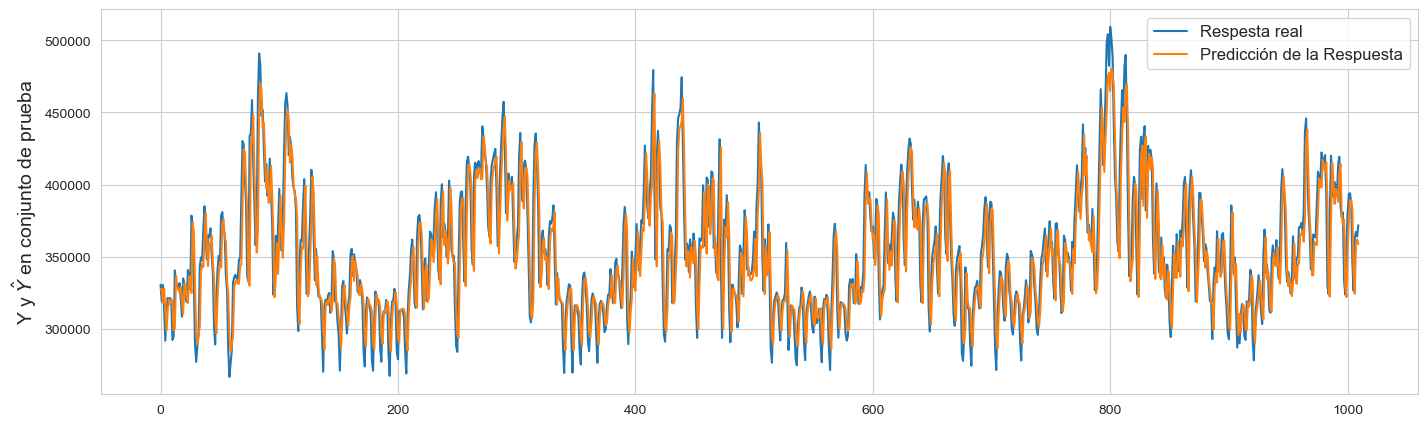

In [92]:
plt.plot(true_series_final)
plt.plot(prediction_test_final)
plt.legend(['Respesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

En conclusión, se tiene un **RECM** igual a $24187.58$ sobre el conjunto de prueba, usando árboles de decisión, y un **RECM** igual a $23465.06$, sobre el conjunto de prueba, usando una red neuronal multicapa, por lo que se concluye que la red neuronal predice mejor que el árbol de desición, en este caso.